In [16]:
import numpy as np 
import pandas as pd 
import time

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split


from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau



/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


In [17]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
    
device

'cuda'

In [18]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [43]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [44]:
def pre_process_data(train_features, train_targets_scored):
    
    feature_columns = list(train_features.columns[1:])
    target_columns = list(train_targets_scored.columns[1:])
    
    removal_list = ['cp_type', 'cp_dose']
    for x in removal_list:
        feature_columns.remove(x)
        
    train_cat = train_features.merge(train_targets_scored, on='sig_id')
    train_cat = train_cat.select_dtypes(exclude=['object'])
    
    dummy_df = train_cat.loc[:, train_cat.columns != 'sig_id']
    df_float = dummy_df.astype(float)
    scaler = MinMaxScaler()
    df_float_scaled = pd.DataFrame(scaler.fit_transform(df_float), columns = df_float.columns)
    df_float_scaled['sig_id'] = train_features['sig_id']
    return(df_float_scaled)

In [53]:
df_float_scaled = pre_process_data(train_features, train_targets_scored)
feature_columns = list(train_features.columns[1:])
removal_list = ['cp_type', 'cp_dose']
for x in removal_list:
    feature_columns.remove(x)
target_columns = list(train_targets_scored.columns[1:])

In [54]:
class TrainDataset(Dataset):
    def __init__(self, df, feature_columns, target_columns, noise ):
        
        self.features  = df[feature_columns].values
        self.targets = df[target_columns].values
        self.noise = noise
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float() 
        
        if self.noise == True:
            feature  = feature + torch.randn_like(feature)/150
            
        target = torch.tensor(self.targets[idx]).float()
        
        return feature,target

In [91]:
full_dataset = TrainDataset(df_float_scaled, feature_columns, target_columns, noise=True)

train_size = int(0.98 * len(full_dataset))  ## 98 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers = 8)

val_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle = True, num_workers = 8)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

584 batches 
8  batches 


In [92]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()
    
def train_step(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    pred = model(x.to(device))
    y = y.float()
    loss = criterion(pred,y.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

In [93]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
        

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(873)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(873, 1048))
        
        self.batch_norm2 = nn.BatchNorm1d(1048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(1048, 2096))
        
        self.batch_norm3 = nn.BatchNorm1d(2096)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(2096, 2096))
        
        self.batch_norm4 = nn.BatchNorm1d(2096)
        self.dropout4 = nn.Dropout(0.5)
        self.dense4 = nn.utils.weight_norm(nn.Linear(2096, 1048))
        
        self.batch_norm5 = nn.BatchNorm1d(1048)
        #self.dropout5 = nn.Dropout(0.5)
        self.dense5 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.leaky_relu(self.dense3(x))
        
        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = F.leaky_relu(self.dense4(x))
        
        x = self.batch_norm5(x)
        #x = self.dropout5(x)
        x = (self.dense5(x))
        
        return x
    
    
    
model = Model()
model = model.to(device)
model.apply(weights_init)
print(model)

Model(
  (batch_norm1): BatchNorm1d(873, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=873, out_features=1048, bias=True)
  (batch_norm2): BatchNorm1d(1048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=1048, out_features=2096, bias=True)
  (batch_norm3): BatchNorm1d(2096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (dense3): Linear(in_features=2096, out_features=2096, bias=True)
  (batch_norm4): BatchNorm1d(2096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (dense4): Linear(in_features=2096, out_features=1048, bias=True)
  (batch_norm5): BatchNorm1d(1048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense5): Linear(in_features=1048, out_features=206, b

In [94]:
losses = []
val_losses = []
learning_rates = []
average_deltas = []
val_corr=[]

optimizer = optim.Adam(model.parameters(), lr=0.5e-3)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.5, 
                                                 patience=5, 
                                                 eps=1e-5, 
                                                 verbose=True)
criterion = nn.BCEWithLogitsLoss()



showing no improvements


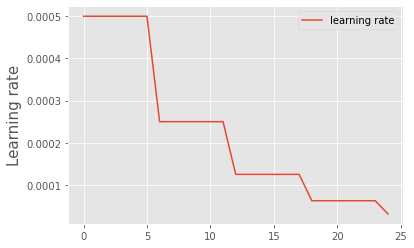

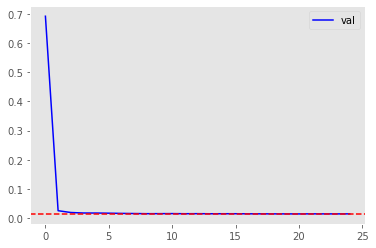

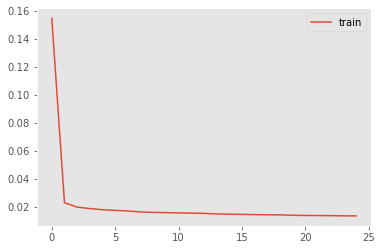

In [95]:
num_epochs=25
best_loss = 100
for epoch in range(num_epochs):
    
    print ("epoch ", epoch+1, " out of ", num_epochs )
    
    with torch.no_grad():
        model.eval()
        val_losses_temp = []
        for x_val, y_val in tqdm(val_loader, desc = "running on test set --"):
            yhat =model(x_val.to(device))  # pred 
            val_loss = criterion(yhat.to(device), y_val.to(device))
            val_losses_temp.append(val_loss.item())  ## metrics 
        val_losses.append(torch.mean(torch.tensor(val_losses_temp)).item())  ## metrics 

    model.train()
    losses_temp = []
    for batch in tqdm(train_loader, desc = " Training batches : "):
        (x_batch, y_batch) = batch
        loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
        losses_temp.append(loss)
    losses.append(torch.mean(torch.tensor(losses_temp)))
    scheduler.step(1.)   ## lr decay caller 
    learning_rates.append(get_lr(optimizer))
    
    
#     with torch.no_grad():
#         model.eval()
#         val_losses_temp = []
#         for x_val, y_val in tqdm(val_loader, desc = "running on test set --"):
#             yhat =model(x_val.to(device))  # pred 
#             val_loss = criterion(yhat.to(device), y_val.to(device))
#             val_losses_temp.append(val_loss.item())  ## metrics 
#         val_losses.append(torch.mean(torch.tensor(val_losses_temp)).item())  ## metrics 
    

    clear_output(wait = True)
    if val_losses[-1] <= best_loss:
        print("Val loss decreased from:", best_loss, " to ", val_losses[-1])
        best_loss = val_losses[-1]
        print("saving model...")
        torch.save(model.state_dict(), "./best_model.pth")

    else: 
        print("showing no improvements")

        
    show_lr(learning_rates)
    plt.plot(val_losses,'b', label = "val")
    plt.axhline(min(val_losses), linestyle = "--", c = "r")
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(losses, label = "train")
    plt.legend()
    plt.grid()
    plt.show()

In [96]:
(min(val_losses))
#0.013776430860161781
#0.013617528602480888

0.01407722756266594

In [68]:
model = Model()
model = model.to(device)
model.load_state_dict(torch.load("./best_model.pth"))
model.eval()

Model(
  (batch_norm1): BatchNorm1d(873, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=873, out_features=1048, bias=True)
  (batch_norm2): BatchNorm1d(1048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=1048, out_features=2096, bias=True)
  (batch_norm3): BatchNorm1d(2096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (dense3): Linear(in_features=2096, out_features=2096, bias=True)
  (batch_norm4): BatchNorm1d(2096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (dense4): Linear(in_features=2096, out_features=1048, bias=True)
  (batch_norm5): BatchNorm1d(1048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense5): Linear(in_features=1048, out_features=206, b

In [70]:
test_df = pre_process_data(test_features, submission )
test_dataset = TrainDataset(test_df, feature_columns, target_columns, noise=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers = 8)

In [71]:
list_of_preds=[]
with torch.no_grad():
    model.eval()
    for x_test, y_test in tqdm(test_loader, desc = "running on test set --"):
        pred =model(x_test.to(device, dtype=torch.float))  # pred 
        pred = pred.cpu()
        pred = pred.sigmoid()
        list_of_preds.append(list(pred[0].numpy()))

In [72]:
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')
sub_cp = submission
sub_cp.to_csv('./submission_cp.csv', index=None, header=True)

In [73]:
import csv 
a = list_of_preds  
with open('./submission_cp.csv', "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(a)

In [74]:
final_sub = pd.read_csv('./submission_cp.csv', header = None)
final_sub.head()
final_sub.columns = submission.columns[1:]
final_sub["sig_id"] = submission["sig_id"]
good_cols = np.roll(final_sub.columns.values, 1)
final_sub = final_sub[good_cols]
final_sub.to_csv("./submission.csv", index=False)
final_sub

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001026,0.000174,0.000683,0.006130,0.005575,0.002407,0.001025,0.002464,0.000201,...,0.000849,0.000116,0.000668,0.000145,0.000085,0.000168,0.000082,0.000960,0.005076,0.005476
1,id_001897cda,0.000951,0.000252,0.002280,0.002907,0.006665,0.001122,0.001050,0.005181,0.000547,...,0.000975,0.000305,0.001664,0.000063,0.000376,0.000273,0.000392,0.001351,0.008706,0.002837
2,id_002429b5b,0.000219,0.000055,0.000156,0.001202,0.001170,0.000186,0.000189,0.000615,0.000026,...,0.000231,0.000060,0.000177,0.000047,0.000031,0.000050,0.000026,0.000300,0.000231,0.000542
3,id_00276f245,0.001115,0.000104,0.000670,0.001471,0.002402,0.000720,0.000344,0.002340,0.000077,...,0.000287,0.000116,0.000311,0.000144,0.000287,0.000116,0.000211,0.000462,0.001068,0.002314
4,id_0027f1083,0.001020,0.000206,0.000586,0.002377,0.002722,0.000805,0.000862,0.001138,0.000077,...,0.000427,0.000227,0.000549,0.000249,0.000180,0.000188,0.000174,0.000570,0.000528,0.001522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,0.000982,0.000279,0.000757,0.001111,0.008864,0.001866,0.000236,0.005377,0.000097,...,0.000200,0.000284,0.000424,0.000088,0.000159,0.000271,0.000156,0.000346,0.004426,0.000518
3978,id_ff925dd0d,0.002841,0.000428,0.000619,0.003239,0.005409,0.002120,0.001520,0.001584,0.000161,...,0.000582,0.000249,0.000772,0.000253,0.000177,0.000343,0.000263,0.000859,0.001030,0.002227
3979,id_ffb710450,0.000975,0.000173,0.000478,0.002148,0.003101,0.000866,0.000588,0.001732,0.000079,...,0.000417,0.000159,0.000381,0.000121,0.000099,0.000174,0.000086,0.000478,0.001007,0.001676
3980,id_ffbb869f2,0.001130,0.000127,0.000435,0.002765,0.002384,0.000856,0.000512,0.001510,0.000090,...,0.000407,0.000081,0.000343,0.000143,0.000141,0.000133,0.000110,0.000547,0.000732,0.003242
